<a href="https://colab.research.google.com/github/tevfikcagridural/Steel_Defect_Detection/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Connect to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pathlib import Path
import shutil

dest = Path('/content/')

# Check the zip files exist and downlowad if they're not in dest
# Train Images
if not Path(dest.joinpath('train_images.zip')).exists():
  zip_train = Path('/content/drive/MyDrive/severstaal-steel-defect/train_images.zip')
  shutil.copy(zip_train, dest)

# Test Images
if not Path(dest.joinpath('test_images.zip')).exists():
  zip_test = Path('/content/drive/MyDrive/severstaal-steel-defect/test_images.zip')
  shutil.copy(zip_test, dest)

# Train CSV
if not Path(dest.joinpath('train.csv.zip')).exists():
  zip_train_csv = Path('/content/drive/MyDrive/severstaal-steel-defect/train.csv.zip')
  shutil.copy(zip_train_csv, dest)

In [5]:
import zipfile

# Unzip images
zipfile_train = 'train_images.zip'
zipfile_test = 'test_images.zip'

if not Path(dest.joinpath('train_images/')).is_dir():
  with zipfile.ZipFile(zipfile_train) as ztr:
    ztr.extractall('train_images')

if not Path(dest.joinpath('test_images/')).is_dir():
  with zipfile.ZipFile(zipfile_test) as zte:
    zte.extractall('test_images')

# Load images

In [6]:
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [7]:
# load dataframe
train_csv = pd.read_csv("/content/train.csv.zip", dtype='str')

In [8]:
SEED = 42
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
TARGET_SIZE =  (256, 1600)

In [9]:
train_datagen = ImageDataGenerator(validation_split=0.25)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv.iloc[:,:2],
    directory='../content/train_images/',
    x_col = 'ImageId',
    y_col = 'ClassId',
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = SEED,
    class_mode = CLASS_MODE,
    target_size = TARGET_SIZE
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv.iloc[:,:2],
    directory='../content/train_images/',
    x_col = 'ImageId',
    y_col = 'ClassId',
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = SEED,
    class_mode = CLASS_MODE,
    target_size = TARGET_SIZE
)

Found 5322 validated image filenames belonging to 4 classes.
Found 1773 validated image filenames belonging to 4 classes.


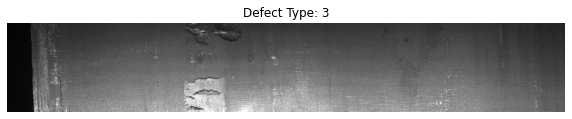

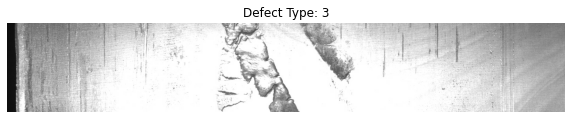

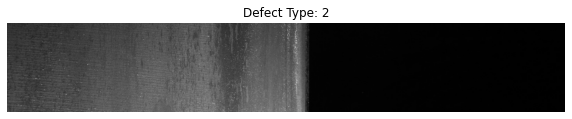

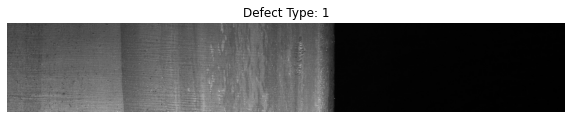

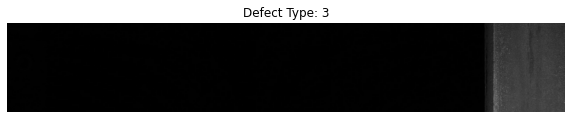

In [10]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

for i in range(5):
  x, y = next(train_generator)
  image = x[0, :, :, :] #First image on batch
  true_index = np.argmax(y[0]) #index of ene-hot encoded label 
  plt.figure(figsize=(10,10))
  ax = plt.subplot(5, 1, i+1)
  ax.imshow(image.astype('uint8'))
  ax.axis('off')
  plt.title("Defect Type: " + get_class_string_from_index(true_index))
  plt.show()

# Modelling MobileNetV2
MobileNetV2 expects array values to be between -1 and 1. However, the images are between 0 and 255. So, the images need be scaled. Additionally, augmentation of the images provides more training source for the model.

In [11]:
# To rescale the values between [-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

## Compliing the base model
I don't want to loose any information from the images. So input shape will be same with the images, plus number of channels. Also exluding the final(top) layer is necessarry. Because a customized layer for this problem will be added. The the other layers will work as a feature extractors.

But before that. I'll have a look the base model structure and features

In [12]:
INPUT_SHAPE = TARGET_SIZE + (3, ) 
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 800, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 800, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 800, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

For now almost all params are trainable. But doing so will cause loosing the weights of pre-training. To aviod it before fitting the model to our data, I'll set all layers of the base model to non-trainable. Therefore only the layers I add will learn.  


At first a pooling layer to reduce the number of parameters with an input of feature extraction layers' output


In [14]:
# Shape of the extracted features which is the final layer for now
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 50, 1280)


In [15]:
# Set the global average pooling layer and calculate its output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
# And a final prediction layer with the number of classes

NUMBER_OF_CLASSES = 4

prediction_layer = (
    tf.keras.
    layers.
    Dense(NUMBER_OF_CLASSES,
          kernel_regularizer=tf.keras.regularizers.l2(0.001))
    )

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [17]:
# Set the base model layer's trainable false to keep the pre-trained weights
base_model.trainable = False

In [18]:
# Input layer with images shape
inputs = tf.keras.Input(shape=(256, 1600, 3))

# Augmentations layer
x = data_augmentation(inputs)

# Rescaling layer
x = preprocess_input(x)

# Add base model layers. 
x = base_model(x, training=False)

# Pooling layer
x = global_average_layer(x)

# Add a dropout layer to prevent overfitting.
# more info: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
x = tf.keras.layers.Dropout(0.2)(x)

# Final prediction layer
outputs = prediction_layer(x)

# Instantiate the complete model
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])

In [20]:
# Structure of the final model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 1600, 3)]    0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 1600, 3)      0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 50, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
# Weights and biases
len(model.trainable_variables)

2

In [22]:
# Without learning anything what is the loss and accuracy on valid set
loss0, accuracy0 = model.evaluate(valid_generator)

56/56 [==============================] - 38s 592ms/step - loss: 1.3875 - accuracy: 0.2728


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.40
initial accuracy: 0.26


In [24]:
# Train the added layers with complete model for 5 epochs
initial_epochs = 5

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

Epoch 1/5
167/167 [==============================] - 139s 814ms/step - loss: 1.0376 - accuracy: 0.6881 - val_loss: 0.9183 - val_accuracy: 0.7146
Epoch 2/5
167/167 [==============================] - 135s 805ms/step - loss: 0.9074 - accuracy: 0.7255 - val_loss: 0.8688 - val_accuracy: 0.7259
Epoch 3/5
167/167 [==============================] - 134s 803ms/step - loss: 0.8816 - accuracy: 0.7358 - val_loss: 0.8492 - val_accuracy: 0.7253
Epoch 4/5
167/167 [==============================] - 135s 806ms/step - loss: 0.8406 - accuracy: 0.7495 - val_loss: 0.8377 - val_accuracy: 0.7315
Epoch 5/5
167/167 [==============================] - 134s 804ms/step - loss: 0.8272 - accuracy: 0.7537 - val_loss: 0.8192 - val_accuracy: 0.7428


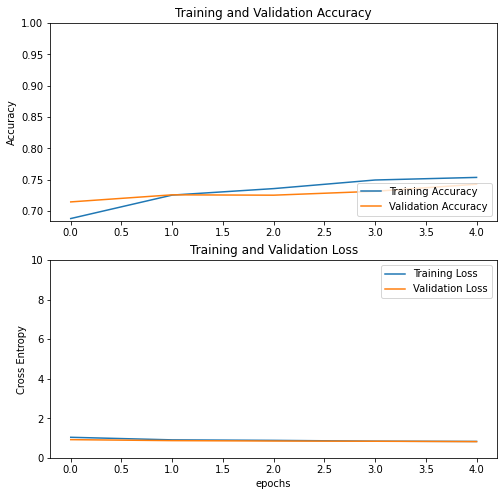

In [25]:
# Plot the loss and accuracy by epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()


## Fine tuning
Learning with only the top/prediction layer the model reached to around %75 accuracy. I'll set some of the base model's layers to trainable. So the model can learn more from the data.

In [26]:
# Set all layers to trainable
base_model.trainable = True

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [28]:
# Set first 140 layers back to non-trainable
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [29]:
# Compile the model again with same loss func and optimizer
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [30]:
# Structure for the fine tunable model.
# Here number of trainable params is imoprtant 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 1600, 3)]    0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 1600, 3)      0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 50, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [31]:
# Train the model for additional 10 epochs
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Epoch 5/15
167/167 [==============================] - 153s 892ms/step - loss: 0.8297 - accuracy: 0.7590 - val_loss: 0.8118 - val_accuracy: 0.7766
Epoch 6/15
167/167 [==============================] - 148s 886ms/step - loss: 0.7458 - accuracy: 0.7966 - val_loss: 0.7513 - val_accuracy: 0.8376
Epoch 7/15
167/167 [==============================] - 148s 887ms/step - loss: 0.6927 - accuracy: 0.8231 - val_loss: 0.6845 - val_accuracy: 0.8156
Epoch 8/15
167/167 [==============================] - 148s 885ms/step - loss: 0.6869 - accuracy: 0.8196 - val_loss: 0.6858 - val_accuracy: 0.8280
Epoch 9/15
167/167 [==============================] - 148s 888ms/step - loss: 0.6565 - accuracy: 0.8490 - val_loss: 0.6627 - val_accuracy: 0.8404
Epoch 10/15
167/167 [==============================] - 149s 889ms/step - loss: 0.6449 - accuracy: 0.8499 - val_loss: 0.6703 - val_accuracy: 0.8150
Epoch 11/15
167/167 [==============================] - 148s 886ms/step - loss: 0.6475 - accuracy: 0.8473 - val_loss: 0.6311

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


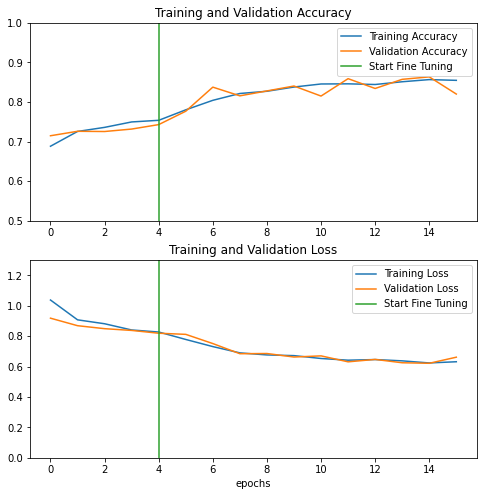

In [33]:
# Plot the accuracy and loss of total learning process
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()


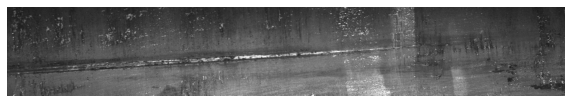

True label: 3
Predicted label: 3


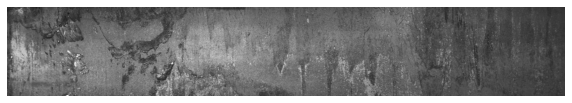

True label: 4
Predicted label: 4


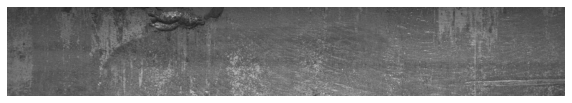

True label: 4
Predicted label: 3


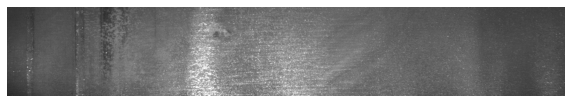

True label: 3
Predicted label: 3


In [34]:
# Predict 4 images with its true labels
for i in range(4):
  x, y = next(valid_generator)
  image = x[0, :, :, :]
  true_index = np.argmax(y[0])
  plt.figure(figsize=(10,10))
  ax = plt.subplot(5, 1, i+1)
  ax.imshow(image.astype('uint8'))
  ax.axis('off')
  plt.show()


  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  predicted_index = np.argmax(prediction_scores)
  print("True label: " + get_class_string_from_index(true_index))
  print("Predicted label: " + get_class_string_from_index(predicted_index))
